# Data Analysis of US Housing Data and Prediction on House Demand
### LING WEI JIET, P145217


This analysis explores trends in the U.S. housing market, focusing on historical data and forecasting future house demand. By examining key patterns and applying time series models, we aim to better understand market dynamics and provide insights for stakeholders.


### Data Analysis Using Hive and Python  


Hive is a data warehouse system built on Hadoop that allows querying large datasets using HiveQL. It is used in this project to efficiently manage and query large-scale data. Hive enables creation of partitioned tables, which significantly improves query performance for grouping and filtering operations on large datasets.  
Python will be used to query Hive tables, load the results into DataFrames using libraries such as Impala, and perform data analysis and visualization using numpy, pandas, matplotlib, and seaborn.

### ETL Process

<b>Dataset Name: U.S. Home Sales, 1963-2016</b>  
Extraction is simply done by downloading the data from public [Tableu dataset website](https://public.tableau.com/app/learn/sample-data) manually. The data is manually upload into Hive through Ambari HiveView.
<br></br>
Transformation is done by filtering data columns/rows that are needed. Data cleaning and any transformation is also done here if needed. However, since the data is well structured, it is pretty straight forward to clean and transformation into desired format for analysis.
<br></br>
Finally, the cleaned data is loaded into a new table. The new table is partitioned to increase query performance. 

### Data exploration

In [69]:
# Set up the connection to virtual machine and hive
from impala.dbapi import connect

conn = connect(
    host='127.0.0.1',
    port=10000,
    user='maria_dev',
    database='default',
    auth_mechanism='PLAIN'
)

cursor = conn.cursor()
cursor.execute('SHOW TABLES')
print(cursor.fetchall())

[('clean_houses',), ('houses',), ('movie_names',), ('ratings',)]


In [3]:
# Library for data processing
import pandas as pd
import numpy as np
from impala.error import ProgrammingError
import matplotlib.pyplot as plt
from IPython.display import display

# Helper function to populate a dataframe with HiveQl query result
def execute_to_df(query, verbose = True):
    
    # Query take HiveQL query
    # col_names is a list of names, matching the number of columns, optional
    printv("="*20, verbose)
    printv("Executing ...\n>>>", verbose)
    printv(query, verbose)        
    cursor.execute(query)
    printv("Fetched result:", verbose)
    
    # Return data in a dataframe if there is output from HiveQL execution
    # If success but no result (DML/DDL), then need to handle the exception
    try:
        result = cursor.fetchall()
    except ProgrammingError as e:
        if "no results" in str(e):
            print("Operation success, no results to fetch.")
            return(False)
        else:
            raise
    
    if len(result): # If it has result
        df = pd.DataFrame(result)
        df.columns = [item[0] for item in cursor.description] # Fill in the column name
        return df
    
    return "Empty rows fetched."

def printv(string, verbose):
    if verbose:
        print(string)

In [4]:
print("Checking data dimension...\n")

print("Row count: ", end = "")
print(execute_to_df("SELECT COUNT(1) FROM houses", False).iloc[0,0])

print("Column count: ", end = "")
print(execute_to_df("DESCRIBE houses", False).shape[0])

Checking data dimension...

Row count: 20404
Column count: 20


In [5]:
# Check some sample data
execute_to_df("SELECT * FROM houses WHERE per_name < '2001-01-01' AND per_name > '2000-01-01'")

Executing ...
>>>
SELECT * FROM houses WHERE per_name < '2001-01-01' AND per_name > '2000-01-01'
Fetched result:


,houses.per_idx,houses.per_name,houses.cat_idx,houses.cat_code,houses.cat_desc,houses.cat_indent,houses.dt_idx,houses.dt_code,houses.dt_desc,houses.dt_unit,houses.et_idx,houses.et_code,houses.et_desc,houses.et_unit,houses.geo_idx,houses.geo_code,houses.geo_desc,houses.is_adj,houses.val,houses.serialid
0,446,2000-02-01,1,SOLD,New Single-family Houses Sold,0,1,TOTAL,All Houses,K,0,,,,4,SO,South,0,37.0,9745
1,446,2000-02-01,1,SOLD,New Single-family Houses Sold,0,6,AVERAG,Average Sales Price,DOL,0,,,,1,US,United States,0,199200.0,9954
2,446,2000-02-01,1,SOLD,New Single-family Houses Sold,0,0,,,,6,E_AVERAG,Relative Standard Error for Average Sales Price,PCT,1,US,United States,0,4.0,9955
3,446,2000-02-01,1,SOLD,New Single-family Houses Sold,0,5,MEDIAN,Median Sales Price,DOL,0,,,,1,US,United States,0,162400.0,9956
4,446,2000-02-01,1,SOLD,New Single-family Houses Sold,0,0,,,,5,E_MEDIAN,Relative Standard Error for Median Sales Price,PCT,1,US,United States,0,3.0,9957
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,456,2000-12-01,3,FORSALE,New Single-family Houses For Sale,0,1,TOTAL,All Houses,K,0,,,,3,MW,Midwest,0,65.0,10520
568,456,2000-12-01,3,FORSALE,New Single-family Houses For Sale,0,0,,,,1,E_TOTAL,Relative Standard Error for All Houses,PCT,3,MW,Midwest,0,7.0,10521
569,456,2000-12-01,3,FORSALE,New Single-family Houses For Sale,0,1,TOTAL,All Houses,K,0,,,,4,SO,South,0,146.0,10522
570,456,2000-12-01,3,FORSALE,New Single-family Houses For Sale,0,0,,,,1,E_TOTAL,Relative Standard Error for All Houses,PCT,4,SO,South,0,5.0,10523


We see that the data follows the structure:
- Each row is indexed by the month, and have main information such as house category (`cat`), description (`dt`), error metric (`et`), geographical information (`geo`), and our target variable value (`val`).
- More importantly, the meaning of the value is dependent on either description or error metric, where "All Houses" under `dt_desc` refers to number of houses, "E_AVERAG" under `et_code` refers to relative standard error for average sales price in percentage 
- There are some redundant columns, eg: `dt_idx`, `dt_code`, `dt_desc` all refers to the same thing with different representation (index, code, english description etc.)

In [6]:
# Get unique values and value counts in each column, concatenated together for an overview
# Takes ~10 seconds to finish
res = execute_to_df("DESCRIBE houses") # Get column names

unique_df = pd.DataFrame()
for col in res.col_name:
    query = 'SELECT DISTINCT ' + col + ' FROM houses'
    temp = execute_to_df(query, False) # Not verbose, too long
    unique_df = pd.concat([unique_df,temp], axis = 1)
    # Check unique_def next

Executing ...
>>>
DESCRIBE houses
Fetched result:


In [7]:
# Check what value is actually present
unique_df.head(10)

,per_idx,per_name,cat_idx,cat_code,cat_desc,cat_indent,dt_idx,dt_code,dt_desc,dt_unit,et_idx,et_code,et_desc,et_unit,geo_idx,geo_code,geo_desc,is_adj,val,serialid
0,1.0,1963-01-01,1.0,ASOLD,Annual Rate for New Single-family Houses Sold,0.0,0.0,,,,0.0,,,,1.0,MW,Midwest,0.0,NaN,1
1,2.0,1963-02-01,2.0,FORSALE,New Single-family Houses For Sale,NaN,1.0,AVERAG,All Houses,DOL,1.0,E_AVERAG,Relative Standard Error for All Houses,PCT,2.0,NE,Northeast,1.0,1.0,2
2,3.0,1963-03-01,3.0,SOLD,New Single-family Houses Sold,NaN,2.0,COMPED,Average Sales Price,K,2.0,E_COMPED,Relative Standard Error for Average Sales Price,NaN,3.0,SO,South,NaN,2.0,3
3,4.0,1963-04-01,NaN,NaN,NaN,NaN,3.0,MEDIAN,Houses that are Completed,MO,3.0,E_MEDIAN,Relative Standard Error for Houses that are Co...,NaN,4.0,US,United States,NaN,3.0,4
4,5.0,1963-05-01,NaN,NaN,NaN,NaN,4.0,MMTHS,Houses that are Not Started,NaN,4.0,E_MMTHS,Relative Standard Error for Houses that are No...,NaN,5.0,WE,West,NaN,4.0,5
5,6.0,1963-06-01,NaN,NaN,NaN,NaN,5.0,MONSUP,Houses that are Under Construction,NaN,5.0,E_MONSUP,Relative Standard Error for Houses that are Un...,NaN,NaN,NaN,NaN,NaN,5.0,6
6,7.0,1963-07-01,NaN,NaN,NaN,NaN,6.0,NOTSTD,Median Number of Months For Sale Since Completion,NaN,6.0,E_NOTSTD,Relative Standard Error for Median Number of M...,NaN,NaN,NaN,NaN,NaN,6.0,7
7,8.0,1963-08-01,NaN,NaN,NaN,NaN,7.0,TOTAL,Median Sales Price,NaN,7.0,E_TOTAL,Relative Standard Error for Median Sales Price,NaN,NaN,NaN,NaN,NaN,7.0,8
8,9.0,1963-09-01,NaN,NaN,NaN,NaN,8.0,UNDERC,Months' Supply at Current Sales Rate,NaN,8.0,E_UNDERC,Relative Standard Error for Months' Supply at ...,NaN,NaN,NaN,NaN,NaN,8.0,9
9,10.0,1963-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0,10


In [8]:
# Check number of unique values
(unique_df.apply(pd.Series.count, axis=0))

per_idx         646
per_name        646
cat_idx           3
cat_code          3
cat_desc          3
cat_indent        1
dt_idx            9
dt_code           9
dt_desc           9
dt_unit           4
et_idx            9
et_code           9
et_desc           9
et_unit           2
geo_idx           5
geo_code          5
geo_desc          5
is_adj            2
val            1739
serialid      20404
dtype: int64

In [9]:
# To confirm whether dt_code and et_code is mutually exclusive or not
execute_to_df("""
    SELECT COUNT(1)
    FROM houses
    WHERE COALESCE(TRIM(dt_code), '') != ''
      AND COALESCE(TRIM(et_code), '') != ''
    LIMIT 20
""")

Executing ...
>>>

    SELECT COUNT(1)
    FROM houses
    WHERE COALESCE(TRIM(dt_code), '') != ''
      AND COALESCE(TRIM(et_code), '') != ''
    LIMIT 20

Fetched result:


,_c0
0,0


We identified several variables that are redundant or meaningless and will be dropped:  
- `per_idx`  
- `cat_idx`  
- `cat_indent`  
- `dt_idx`  
- `et_idx`  
- `et_unit`  
- `geo_idx`  
- `serial_id`  
<br></br>
We also found that `dt_code` and `et_code` are mutually exclusive, that means the metric that we are interested in (number of houses sold, total sales etc.) are purely in rows where `dt_code` hold a value, and we will drop all rows and columns related to the error metrics (rows where `et_code` has a value, columns of prefixed by `et_...`
<br></br>
There are also null value in target variable `val` in which we have to investigate why

In [10]:
# See rows where `val` is missing
print(execute_to_df("""
    SELECT * 
    FROM houses
    WHERE val IS NULL
"""))

# Looks some something to do with dt_code/desc
print(execute_to_df("""
    SELECT DISTINCT dt_code, dt_desc
    FROM houses
    WHERE val IS NULL
"""))

# Confirm presence of NULL outside of MMTHS and MONSUP
print(execute_to_df("""
    SELECT COUNT(1)
    FROM houses
    WHERE val IS NOT NULL
        AND dt_code IN ('MMTHS', 'MONSUP')
"""))

Executing ...
>>>

    SELECT * 
    FROM houses
    WHERE val IS NULL

Fetched result:
      houses.per_idx houses.per_name  houses.cat_idx houses.cat_code  \
0                  1      1963-01-01               3         FORSALE   
1                  1      1963-01-01               3         FORSALE   
2                  2      1963-02-01               3         FORSALE   
3                  2      1963-02-01               3         FORSALE   
4                  3      1963-03-01               3         FORSALE   
...              ...             ...             ...             ...   
1789             645      2016-09-01               3         FORSALE   
1790             645      2016-09-01               3         FORSALE   
1791             646      2016-10-01               3         FORSALE   
1792             646      2016-10-01               3         FORSALE   
1793             646      2016-10-01               3         FORSALE   

                        houses.cat_desc  houses

We investigate why `val` has empty value  

From the output we see that `NULL` value in `val` only occurs for data regarding "Months' Supply at Current Sales Rate" and "Median Number of Months For Sale Since Completion"  
Unfortunately, there is nothing that we can do to impute for or analyse with these missing data, so we will have to discard them. 

In [70]:
# Check the distribution of val within each dt
execute_to_df("""
    SELECT 
        dt_desc as `Description (Within that month)`,
        dt_unit as Unit,
        MIN(val) AS `MINIMUM`,
        AVG(val) AS `AVERAGE`,
        MAX(val) AS `MAXIMUM`,
        PERCENTILE(val, 0.10) AS `10%`,
        PERCENTILE(val, 0.25) AS `25%`,
        PERCENTILE(val, 0.5) AS `MEDIAN`,
        PERCENTILE(val, 0.75) AS `75%`,
        PERCENTILE(val, 0.90) AS `90%`
    FROM houses
    WHERE COALESCE(dt_desc, '') != ''
        AND dt_code NOT IN ('MMTHS','MONSUP')
    GROUP BY dt_desc, dt_unit
""")

Executing ...
>>>

    SELECT 
        dt_desc as `Description (Within that month)`,
        dt_unit as Unit,
        MIN(val) AS `MINIMUM`,
        AVG(val) AS `AVERAGE`,
        MAX(val) AS `MAXIMUM`,
        PERCENTILE(val, 0.10) AS `10%`,
        PERCENTILE(val, 0.25) AS `25%`,
        PERCENTILE(val, 0.5) AS `MEDIAN`,
        PERCENTILE(val, 0.75) AS `75%`,
        PERCENTILE(val, 0.90) AS `90%`
    FROM houses
    WHERE COALESCE(dt_desc, '') != ''
        AND dt_code NOT IN ('MMTHS','MONSUP')
    GROUP BY dt_desc, dt_unit

Fetched result:


,description (within that month),unit,minimum,average,maximum,10%,25%,median,75%,90%
0,All Houses,K,1,158.954924,1389,10.0,29.0,78.5,232.0,390.0
1,Average Sales Price,DOL,39500,184168.725100,384000,68930.0,101525.0,160450.0,269275.0,310750.0
2,Houses that are Completed,K,9,52.457338,199,15.0,18.0,25.0,87.0,108.0
3,Houses that are Not Started,K,3,31.457338,106,8.0,12.0,26.0,49.0,61.0
4,Houses that are Under Construction,K,5,92.617747,336,13.0,19.0,32.0,178.0,212.9
5,Median Sales Price,DOL,17200,123711.764706,321600,23500.0,44300.0,118600.0,190575.0,243900.0


In [12]:
# Get the unit for each category
desc = execute_to_df(
    """
    SELECT DISTINCT dt_desc, dt_unit
    FROM houses     
    WHERE COALESCE(dt_desc, '') != ''
        AND dt_code NOT IN ('MMTHS','MONSUP')
    """)
desc

Executing ...
>>>

    SELECT DISTINCT dt_desc, dt_unit
    FROM houses     
    WHERE COALESCE(dt_desc, '') != ''
        AND dt_code NOT IN ('MMTHS','MONSUP')
    
Fetched result:


,dt_desc,dt_unit
0,All Houses,K
1,Average Sales Price,DOL
2,Houses that are Completed,K
3,Houses that are Not Started,K
4,Houses that are Under Construction,K
5,Median Sales Price,DOL


In [13]:
# Get data to plot the distribution of each category
res = pd.DataFrame()
for des in desc.iloc[:,0]:
    query = f"""
        SELECT val
        FROM houses
        WHERE dt_desc == '{des}'
        ORDER BY rand()
        LIMIT 1000
    """ # Wanted to use TABLESAMPLE(1000 ROWS) but this doesnt support filtering
    #print(query)
    temp = execute_to_df(query)
    res = pd.concat([res,temp], axis=1)
res

Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'All Houses'
        ORDER BY rand()
        LIMIT 1000
    
Fetched result:
Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'Average Sales Price'
        ORDER BY rand()
        LIMIT 1000
    
Fetched result:
Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'Houses that are Completed'
        ORDER BY rand()
        LIMIT 1000
    
Fetched result:
Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'Houses that are Not Started'
        ORDER BY rand()
        LIMIT 1000
    
Fetched result:
Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'Houses that are Under Construction'
        ORDER BY rand()
        LIMIT 1000
    
Fetched result:
Executing ...
>>>

        SELECT val
        FROM houses
        WHERE dt_desc == 'Median Sales Price'
        ORDER BY rand()
       

,val,val,val,val,val,val
0,274,106100.0,15,55,10,177500.0
1,40,200200.0,99,8,30,27000.0
2,37,300200.0,84,59,22,70100.0
3,80,98800.0,107,10,21,194100.0
4,203,65700.0,19,47,124,52300.0
...,...,...,...,...,...,...
995,75,NaN,17,39,7,NaN
996,29,NaN,72,22,101,NaN
997,639,NaN,111,21,252,NaN
998,25,NaN,102,9,9,NaN


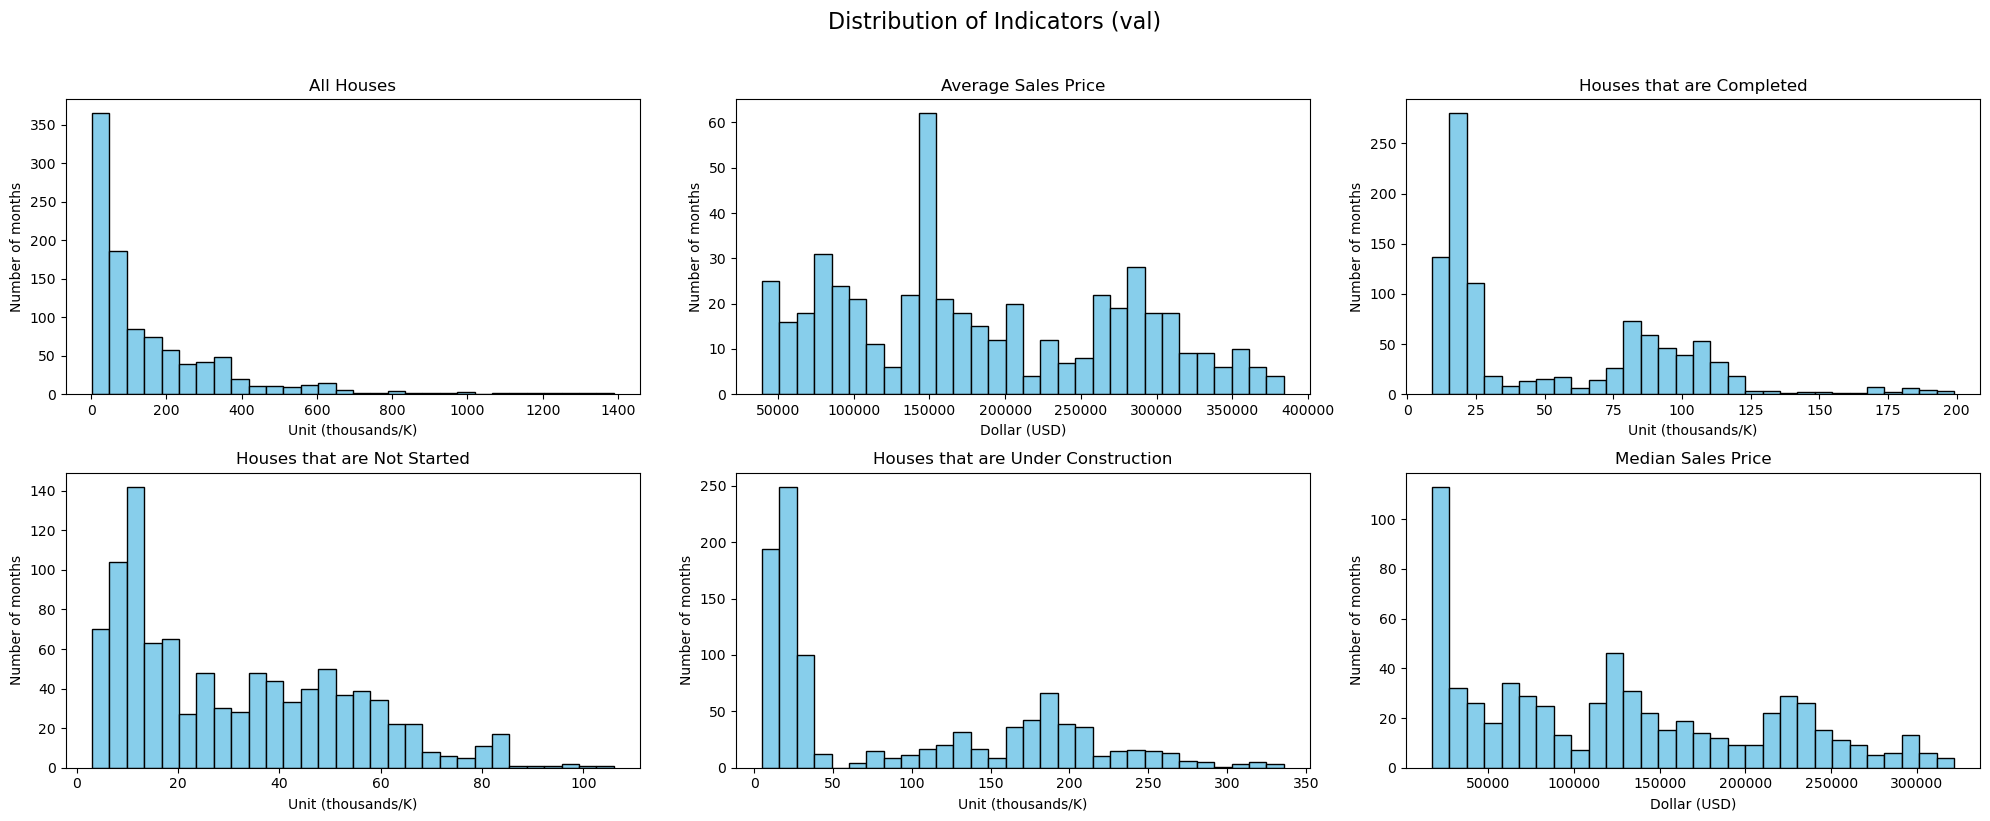

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(20, 8)) 
df = res
df.columns = desc.iloc[:, 0]

axes = axes.flatten()  # Flatten to 1D for easy indexing
xlabs = ['Unit (thousands/K)' if a == 'K' else 'Dollar (USD)' for a in desc.iloc[:, 1]]

for i, col in enumerate(df.columns):
    if i < len(axes):
        axes[i].hist(df[col], bins=30, color='skyblue', edgecolor='black')
        axes[i].set_title(col)
        axes[i].set_xlabel(xlabs[i])
        axes[i].set_ylabel('Number of months')

plt.suptitle('Distribution of Indicators (val)', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### Creating and loading data into the cleaned table


After determining which columns and subset of data that we wanted, we proceed to load it into a new table `cleaned_houses`.  
Since the important variable `val` is defined by the value in column `cat_desc`, we are sure that every query will need to filter by `cat_desc` before any other filtering condition or grouping etc, therefore it is being partitioned on `cat_desc`  
Partitioning makes the data with the same value in the partitioned column to be placed physically closer in the storage, and can make query that filters based on that column to be faster by skipping the scanning of other unrelated partitions.  
<br></br>
Note: In our implementation, inserting data in partitioned table in Hive require some parameters to be changed, which cannot be achieved during runtime through Python Impala library.   
`    SET hive.exec.dynamic.partition=true;
    SET hive.exec.dynamic.partition.mode=nonstrict;`  
We can either, 1. change the parameter value directly in the Hive XML config file, or 2. Change it during runtime before insertion query directly in the Ambari Hive View.  
We choose the second method as to not mess with the environment unncessarily


In [15]:
#Create new partitioned table
query = '''
    CREATE TABLE IF NOT EXISTS clean_houses (
        cat_desc STRING,
        dt_unit STRING,
        geo_desc STRING,
        is_adj INT,
        val INT,
        per_name DATE
    )
    PARTITIONED BY (dt_desc STRING)
    STORED AS ORC
'''
# execute_to_df(query)

# Insert data with the required transformations
query = '''
    SET hive.exec.dynamic.partition=true;
    SET hive.exec.dynamic.partition.mode=nonstrict;

    INSERT OVERWRITE TABLE clean_houses
    PARTITION (dt_desc)
    SELECT 
        cat_desc,
        dt_unit,
        geo_desc,
        is_adj,
        val,
        per_name,
        dt_desc
    FROM houses
        WHERE COALESCE(dt_desc, '') != ''
        AND dt_code NOT IN ('MMTHS','MONSUP')
'''

# cursor.execute(query)
# This will throw error because hive.exec parameters cannot be changed during runtime through Impala in python, 
# The insert statement is executed in the Ambari HiveView directly

We execute the two queries in above cell in Ambari HiveView directly and successfully inserted the data. 
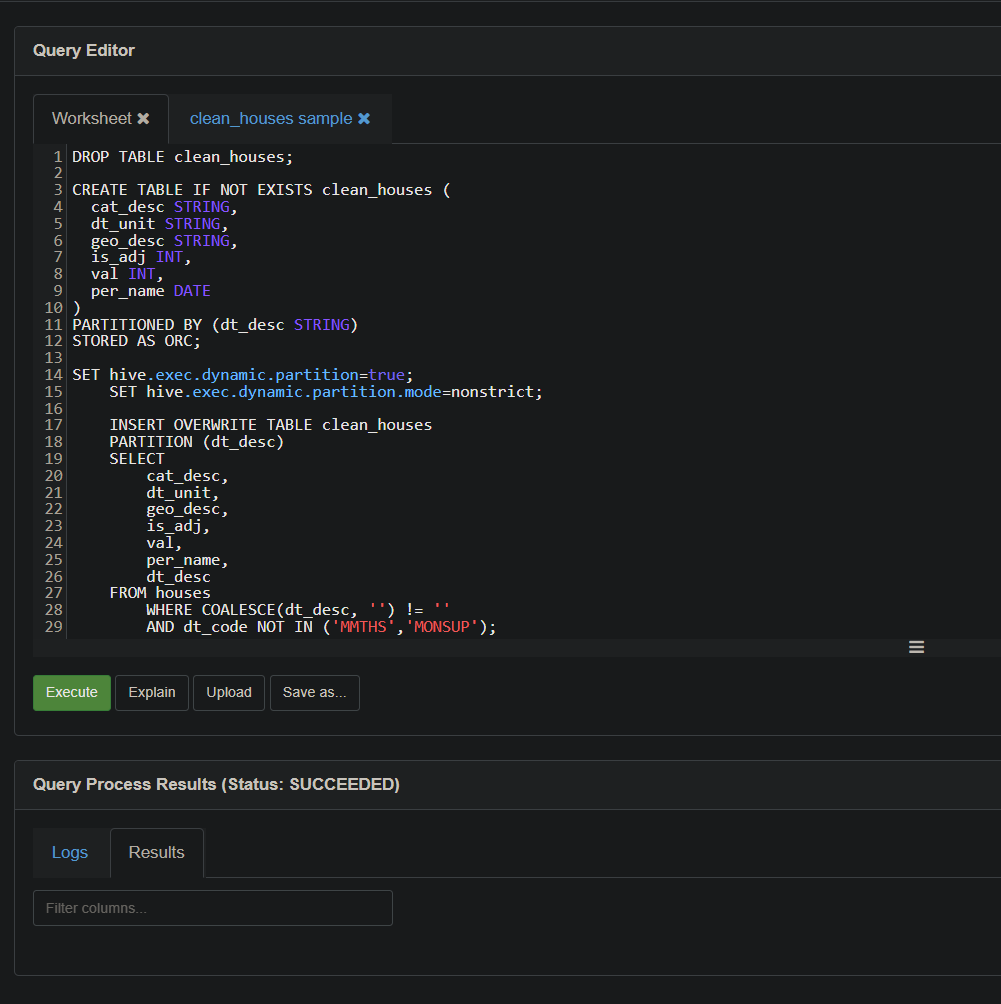

In [16]:
execute_to_df("SELECT * FROM clean_houses LIMIT 5")

Executing ...
>>>
SELECT * FROM clean_houses LIMIT 5
Fetched result:


,clean_houses.cat_desc,clean_houses.dt_unit,clean_houses.geo_desc,clean_houses.is_adj,clean_houses.val,clean_houses.per_name,clean_houses.dt_desc
0,New Single-family Houses Sold,K,United States,0,42,1963-01-01,All Houses
1,Annual Rate for New Single-family Houses Sold,K,United States,1,591,1963-01-01,All Houses
2,New Single-family Houses For Sale,K,United States,0,234,1963-01-01,All Houses
3,New Single-family Houses For Sale,K,United States,1,235,1963-01-01,All Houses
4,New Single-family Houses Sold,K,United States,0,35,1963-02-01,All Houses


# Data visualization and analysis


Before we start, there are a few of terms under `cat_desc`, `dt_desc`, and `is_adj` to be understood here:  
<br></br>
`cat_desc`:
 - <b>New Single-family Houses Sold</b>: Refers to house successfully sold out, represent the demand.
 - <b>New Single-family Houses For Sale</b>: Refers to the house on sales, represent the supply.  
 - <b>Annual Rate for New Single-family Houses Sold</b>: Refers to the seasonally adjusted annual rate (SAAR), representing the estimated total demand in the whole year, if the patterns of current month continue, adjusted for the seasonal fluctuation. This tells us if the actual sales has gone up or gone down, rather than being influenced by the peaks and dips of the seasonality.  
<br></br>
`dt_desc`: These are easier to understand, they are different metric of price, and different types of houses
 - <b>All Houses</b>: Quantity of all types of house    
 - <b>Average Sales Price</b>: Price metrics    
 - <b>Houses that are Completed</b>: Quantity of completed house  
 - <b>Houses that are Not Started</b>:	Quantity of not started house   
 - <b>Houses that are Under Construction</b>: Quantity of under construction house   
 - <b>Median Sales Price</b>: Price metrics  
 <br></br>
 `is_adj`: Whether the value of this row if seasonally adjusted or not

Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'New Single-family Houses Sold'
        AND geo_desc == 'United States'

Fetched result:


,per_name,cat_desc,dt_desc,dt_unit,geo_desc,val
0,1963-01-01,New Single-family Houses Sold,All Houses,K,United States,42
1,1963-02-01,New Single-family Houses Sold,All Houses,K,United States,35
2,1963-03-01,New Single-family Houses Sold,All Houses,K,United States,44
3,1963-04-01,New Single-family Houses Sold,All Houses,K,United States,52
4,1963-05-01,New Single-family Houses Sold,All Houses,K,United States,58
...,...,...,...,...,...,...
641,2016-06-01,New Single-family Houses Sold,All Houses,K,United States,50
642,2016-07-01,New Single-family Houses Sold,All Houses,K,United States,54
643,2016-08-01,New Single-family Houses Sold,All Houses,K,United States,47
644,2016-09-01,New Single-family Houses Sold,All Houses,K,United States,45


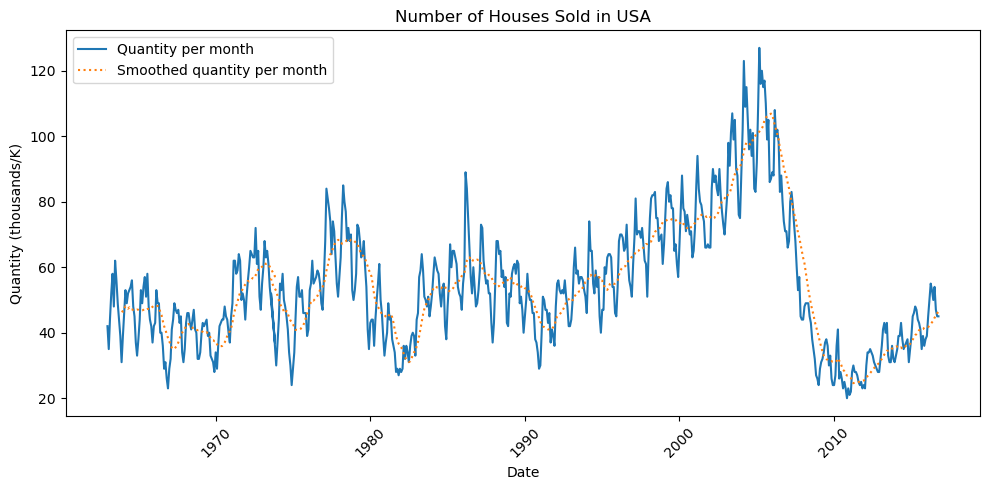

In [36]:
# Get number of total houses sold in the whole United States 
df = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'New Single-family Houses Sold'
        AND geo_desc == 'United States'
""")

display(df)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['per_name'], df['val'], label='Quantity per month')
plt.plot(df['per_name'], df['val'].rolling(window=12).mean(), linestyle=':', label='Smoothed quantity per month') # 12-month smoothed quantity
plt.legend()
plt.xlabel('Date')
plt.ylabel('Quantity (thousands/K)')
plt.title('Number of Houses Sold in USA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

demand_metric = df.loc[:,['per_name','val']] # Save for later use

This graph shows the overall trend of housing demand in USA. Overall, between 1960 to 1990, around 20k to 80k houses are being sold every month in the USA, and around 2000s, it rose to 120k at the peak and crashed to 20k around 2010, this is the famous 2000s Housing Market Crashes in the US. From the graphs, we noticed several patterns:
 - House sales follow a seasonal yearly fluctuation across the months
 - From the smoothed line (smoothed by 12-months window averages) where monthly fluctuation is removed, house sales also follow a cyclical pattern of going up and down with span between 5 to 10 years
 - Before the housing bubbles, it shows relatively stable demand across the year.  
 - After the market crash, there is relatively slow recovery of house sales, but recovered to the level of around 50k around 2016.
<br></br>
For your information, housing bubbles are popped when the market sentiments toward housing value are overly optimistic, and a market correction will surely occur and bring a drastic decrease in housing value [(Source)](https://newsilver.com/the-lender/history-of-housing-market-crashes/). From the hindsight, it is obvious that, previously, the housing demand cycle are relatively stable where the increases span around 4~6 years before going down. However, the demand started to increase linearly, ignoring the monthly fluctuation, since 1990 and continued for 15 years and longer. This begs the questions about, is the increases in houses sold normal? Could we have foreseen the market crash that follows? Naturally, we would want to investigate the supply and demand relationship in the next step.

Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'Annual Rate for New Single-family Houses Sold'
        AND geo_desc == 'United States'

Fetched result:


,per_name,cat_desc,dt_desc,dt_unit,geo_desc,val
0,1963-01-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,591
1,1963-02-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,464
2,1963-03-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,461
3,1963-04-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,605
4,1963-05-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,586
...,...,...,...,...,...,...
641,2016-06-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,558
642,2016-07-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,622
643,2016-08-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,567
644,2016-09-01,Annual Rate for New Single-family Houses Sold,All Houses,K,United States,574


Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'New Single-family Houses For Sale'
        AND geo_desc == 'United States'
        AND is_adj == 0

Fetched result:


,per_name,cat_desc,dt_desc,dt_unit,geo_desc,val
0,1963-01-01,New Single-family Houses For Sale,All Houses,K,United States,234
1,1963-02-01,New Single-family Houses For Sale,All Houses,K,United States,236
2,1963-03-01,New Single-family Houses For Sale,All Houses,K,United States,246
3,1963-04-01,New Single-family Houses For Sale,All Houses,K,United States,254
4,1963-05-01,New Single-family Houses For Sale,All Houses,K,United States,254
...,...,...,...,...,...,...
641,2016-06-01,New Single-family Houses For Sale,All Houses,K,United States,243
642,2016-07-01,New Single-family Houses For Sale,All Houses,K,United States,236
643,2016-08-01,New Single-family Houses For Sale,All Houses,K,United States,242
644,2016-09-01,New Single-family Houses For Sale,All Houses,K,United States,245


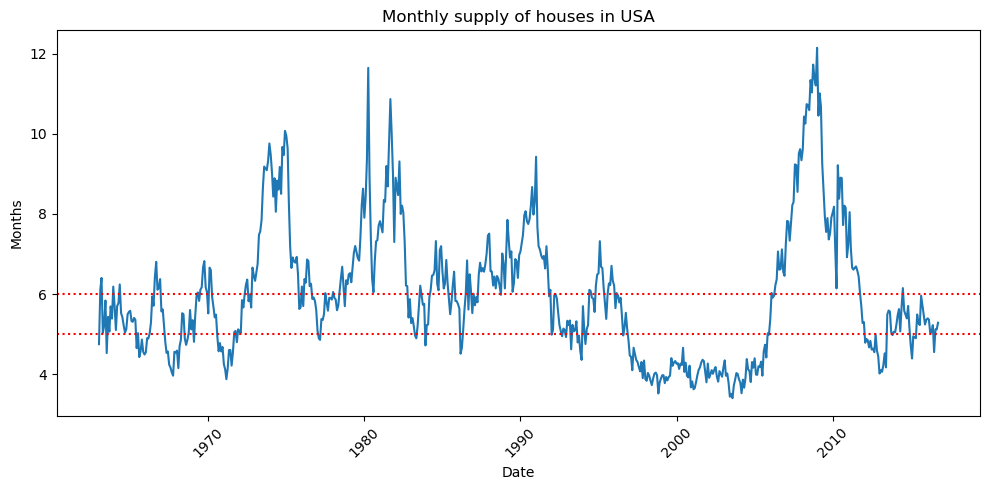

In [40]:
# A good monthly supply of houses is typically 5~6 months
# https://eyeonhousing.org/2024/06/considering-housing-inventory-why-both-new-and-existing-supply-matters/

# Get number of total houses sold in the whole United States 
df = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'Annual Rate for New Single-family Houses Sold'
        AND geo_desc == 'United States'
""")
display(df)

# Get number of total houses sold in the whole United States 
df2 = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, val
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'New Single-family Houses For Sale'
        AND geo_desc == 'United States'
        AND is_adj == 0
""")
display(df2)

monthly_supply = df2.val / (df.val/12)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(df['per_name'], monthly_supply)

plt.axhline(y=5, color='red', linestyle='dotted')
plt.axhline(y=6, color='red', linestyle='dotted')

plt.xlabel('Date')
plt.ylabel('Months')
plt.title('Monthly supply of houses in USA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

monthly_supply_metric = pd.concat([df['per_name'],monthly_supply], axis=1) # Save for later use

This plot shows the monthly supply of houses in USA. The definition of monthly supply is the <b>ratio of new houses for sale to new houses sold</b>. This is a statistics that measure how long would the current new for-sale inventory would last if the rates of sales continue the trend -- an indicator of the supply and demand ratio in one metric. Experts and the industry suggest that 5 ~ 6 months of houses monthly supply is a sign of healthy market [(Source)](https://208.properties/real-estate-insights/healthy-real-estate-market-supply-inventory). High monthly supply means more house to sell than the market demands, and low monthly supply means the demands are high.

From the plot, we can see that:
- Since 1960 to 2000, most of the time this metric fluctutates around 5~6 values. 
- Some peaks happened around 1975, 1980, 1990, 1995, but quickly stabilized back to normal ranges within 2~3 years.
- Monthly supply dropped to historic low (around 3.5 months), and continued for around 7 years, before peaking into historic high of 12 months.

In fact, we can see the peaks all correspond to bad financial weather, such as the 1970s stagflation (stagnant, and high inflation), 1980s recession, and the 2008 financial crisis. This is easy to understand as the purchasing power of the people dropped, and therefore not many people are buying houses. From the graph, 5~6 monthly suppply of housing is indeed the "healthy range" of the market, which the market supply and demand has reach the healthy equilibrium. It is also interesting to see that before every peak, there is a dip that goes lower than 5 months threshold, although it is not conclusive to say dipping below 5 months is a sign of problem, but prolonged period of this metrics staying below 5 months are surely worth paying attention to, especially after the 2000's housing bubbles. 


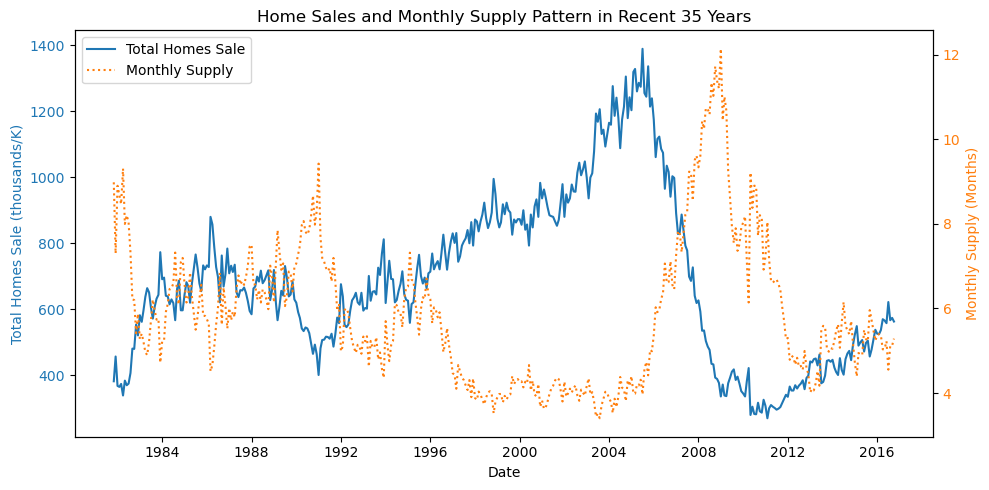

In [41]:
recent_15_yrs_per = df['per_name'].tail(12*35)
recent_15_yrs_demand = df.tail(12*35).val
recent_15_yrs_monthly_supply = monthly_supply.tail(12*35)

# Plot
fig, ax1 = plt.subplots(figsize=(10, 5))

ax2 = ax1.twinx()

line1, = ax1.plot(recent_15_yrs_per, recent_15_yrs_demand, color='tab:blue', label='Total Homes Sale')
line2, = ax2.plot(recent_15_yrs_per, recent_15_yrs_monthly_supply, color='tab:orange',linestyle=':', label='Monthly Supply')

ax1.set_xlabel('Date')
ax1.set_ylabel('Total Homes Sale (thousands/K)', color='tab:blue')
ax2.set_ylabel('Monthly Supply (Months)', color='tab:orange')

ax1.tick_params(axis='y', labelcolor='tab:blue')
ax2.tick_params(axis='y', labelcolor='tab:orange')

plt.title('Home Sales and Monthly Supply Pattern in Recent 35 Years')
plt.xticks(rotation=45)
plt.tight_layout()

lines = [line1, line2]
labels = [line.get_label() for line in lines]
plt.legend(lines, labels, loc='upper left')

plt.show()

Now we look at the relationship between total home sales and the monthly supply of houses. We found that:
- Total home sales and monthly supply of houses are in inverse correlation which demonstrates the fundamental supply-demand relationship.
- Not only they are inverse relationship, monthly supply graph (orange) looks like the right-shifted version of the sales (blue), a lagged indicator to house sales (lags around 4~5 years period). Blue at 1982 corresponds to Orange at 1986; Blue at 1986 corresponds to Orange at 1990; Blue at 1991 corresponds to Orange at 1994; and the most obvious one -- Blue at 2005 corresponds to Orange at 2009.

So far, these observation confirms our previous findings/idea about supply and demand.   
However, there are two period of time where the "right-shifted pattern" or "inverse correlation" doesnt match up:
 - The period after 2000, when the house builder / seller noticed the increase in demand around 1995, they should increase the supply so that it matches the trend of increasing demand. However, strange enough, monthly supply metrics did not increase, until 2005, 10 years after the demand increases compared to the usual 4~5 years lag as noticed previously. This means the increase in demand is higher than anyone would expect, even the supply is being increased to cater for it. For context, US population at 1985, 1995, 2005 are 4.34T, 7.64T, 13T respectively, [(Source)](https://datacommons.org/place/country/USA?mprop=count&popt=Person&hl=en), a 76% increase from 1985 to 1995, and 70% increase from 1995 to 2005, which is within expected growth of population and subsequently the housing needs. Therefore, this unexpectedly high demand is an early sign of speculative buying of home, which the purpose is not to cater for housing needs, instead of seasonal/cyclical fluctuation of supply-demand. 
 - The recovery after 2012 shows positive correlation instead of inverse relationship between the two metrics. The monthly supply metrics recovered to healthy range much faster than the total home sales, which is still lower than pre-2000 volume. It signifies the structural market changes that we are yet to be able to confirm its effect. We would expect the sales volume to go higher when the supply returns to balanced level, the fact it did not means changes to the ability or desire to buy a house. For example, the post crisis banking regulations implemented after 2008 to reduce risk has made it harder to get loan approved, which is a direct consequence of subprime mortgage (mortgage approved for people with low credit score) that contributed to the bubbles [(Source)](https://www.federalreservehistory.org/essays/subprime-mortgage-crisis). Besides that, new generations now form family much later and delay their time to buy a home. Other than that, people's increase in willingness to rent a house instead of buying one might also explain the growth pattern after 2012. 
 
As for recommendation, investors or house buyers should understand the changes in these aspects and properly evaluate how it would affect their plan of successful investment or buying a house as their life goals. For example, as a policymaker, one could consider making a targeted regulations that balanced risk and accessibility, so that first-time house buyer with tighter credit requirement can afford houses, without causing speculative buying from other groups due to loosen criteria. Besides that, house affordability should be directly addressed to favor individual homeownership over large-scale purchase for investment to counteract the power of institutional investments. For individuals looking to buy a house, one should realize the importance of building better credit profiles and plan to save up bigger amount of down payment. He/she could look for early indication of increase in supply before sales volume respond to get the best offer. One should also consider other option for housing such as rent-to-own model etc. For real estate agents, investors, developers, it is even important to fully understand the structural changes, especially when more complex financing options are provided, how will the supply-demand react? Will the rules of "5-6 monthly supply is good indication of healthy market" even holds? They should recognize the changes and challenge their old beliefs to adapt to the new market. 

Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, is_adj, val
    FROM clean_houses
    WHERE dt_desc == 'Median Sales Price'
        AND cat_desc == 'New Single-family Houses Sold'
        AND geo_desc == 'United States'

Fetched result:


,per_name,cat_desc,dt_desc,dt_unit,geo_desc,is_adj,val
286,1986-11-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,94000
287,1986-12-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,95000
288,1987-01-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,98500
289,1987-02-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,95200
290,1987-03-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,98400
...,...,...,...,...,...,...,...
641,2016-06-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,321600
642,2016-07-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,295000
643,2016-08-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,299600
644,2016-09-01,New Single-family Houses Sold,Median Sales Price,DOL,United States,0,314100


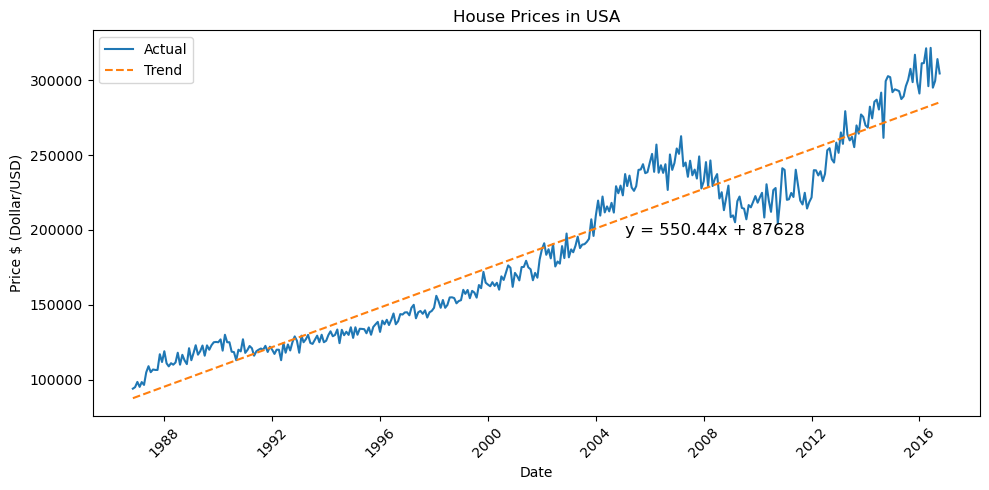

In [21]:
from sklearn.linear_model import LinearRegression

# Get number of total houses sold in the whole United States 
df = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, is_adj, val
    FROM clean_houses
    WHERE dt_desc == 'Median Sales Price'
        AND cat_desc == 'New Single-family Houses Sold'
        AND geo_desc == 'United States'
""")
price_metric = df.loc[:,['per_name','val']]
df = df.tail(12*30)
display(df)

# Plot
# Prepare data
x = np.arange(len(df)).reshape(-1, 1)
y = df['val'].values
model = LinearRegression().fit(x, y)
y_pred = model.predict(x)

# Plot with regression line
plt.figure(figsize=(10, 5))
plt.plot(df['per_name'], y, label='Actual')
plt.plot(df['per_name'], y_pred, label='Trend', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Price $ (Dollar/USD)')
plt.title('House Prices in USA')
plt.xticks(rotation=45)
plt.legend()

# Annotate formula
a, b = model.coef_[0], model.intercept_
plt.text(0.60, 0.5, f'y = {a:.2f}x + {b:.0f}', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

plt.tight_layout()
plt.show()

The plot above shows the house price in USA. We see that:
- The price increase linearly, where the price of a house increase by $550 every year.
- The house price has recovered since the bubbles.
- However, the gradient before bubbles and after bubble seems to be different, where house prices after bubbles are growing at a faster pace.
- The variance in house prices are also bigger than pre-bubble period.

Similar to previous conclusion, the graph of house prices also confirms changes in market after bubbles. Compared to pre-bubble, the house appreciation is even faster, and therefore incentivize people to buy a home earlier. The changes also suggests that older risk assessment models or predictions model might not work that good on market nowadays. The volatility of the house price also make it so that there is a need to properly calculate the best time for market entry for investors or individual buyers. They should factor in potential volatility when planning long term purchase.

Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, SUM(val)
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'Annual Rate for New Single-family Houses Sold'
        AND geo_desc != 'United States' -- Except the total
        AND per_name > '1980-01-01'
    GROUP BY per_name, cat_desc, dt_desc, dt_unit, geo_desc
    ORDER BY per_name

Fetched result:


geo_desc,per_name,Midwest,Northeast,South,West
0,1980-02-01,84,55,261,141
1,1980-03-01,76,49,226,123
2,1980-04-01,71,35,172,91
3,1980-05-01,65,35,252,117
4,1980-06-01,69,39,287,156
...,...,...,...,...,...
436,2016-06-01,75,28,321,134
437,2016-07-01,79,37,364,142
438,2016-08-01,67,24,333,143
439,2016-09-01,73,33,332,136


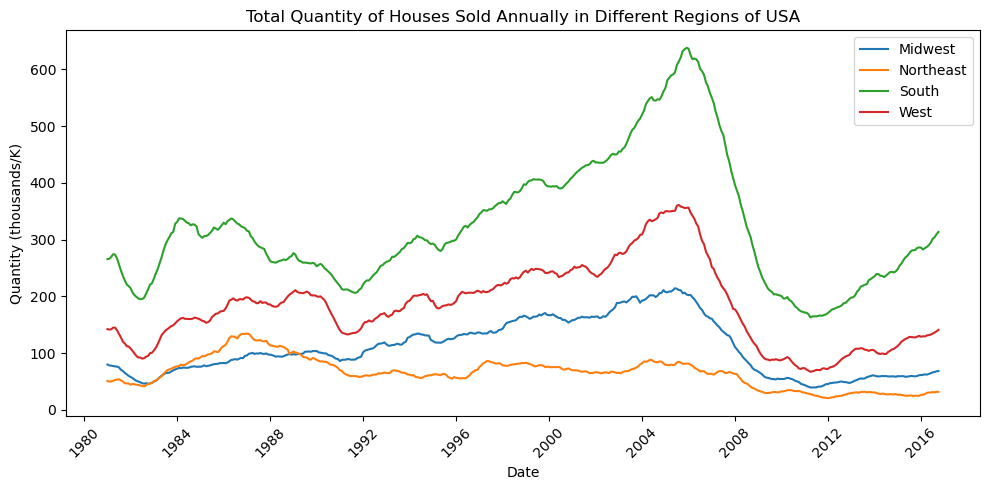

In [44]:
# Geographical proportion to number of house sold
df = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, geo_desc, SUM(val)
    FROM clean_houses
    WHERE dt_desc == 'All Houses'
        AND cat_desc == 'Annual Rate for New Single-family Houses Sold'
        AND geo_desc != 'United States' -- Except the total
        AND per_name > '1980-01-01'
    GROUP BY per_name, cat_desc, dt_desc, dt_unit, geo_desc
    ORDER BY per_name
""")

pivot_df = df.pivot(index='per_name', columns='geo_desc', values='_c5').reset_index() # Each geographical location is now a column
display(pivot_df)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(pivot_df['per_name'], pivot_df.Midwest.rolling(window=12).mean(), label = 'Midwest')
plt.plot(pivot_df['per_name'], pivot_df.Northeast.rolling(window=12).mean(), label = 'Northeast')
plt.plot(pivot_df['per_name'], pivot_df.South.rolling(window=12).mean(), label = 'South')
plt.plot(pivot_df['per_name'], pivot_df.West.rolling(window=12).mean(), label = 'West')

plt.xlabel('Date')
plt.ylabel('Quantity (thousands/K)')
plt.title('Total Quantity of Houses Sold Annually in Different Regions of USA')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

When looking from the inside of USA, the four regions of midwest, northeast, south, and west regions are following the overall patterns of whole USA. Some minor changes that we noted are changes in midwest and northeast, where northeast was selling more houses than midwest region in the earlier period, but got beaten to by midwest nearing the bubble. South region always owns the biggest proportion of house sold at all times, and even higher during the bubbles. Interestingly, number of houses sold in northeast region is very minimally affected by the bubble, and do not recover after the bubble.

The suggestion is to try to tap into housing market in midwest and northeast, which should have grown back to higher level but did not.

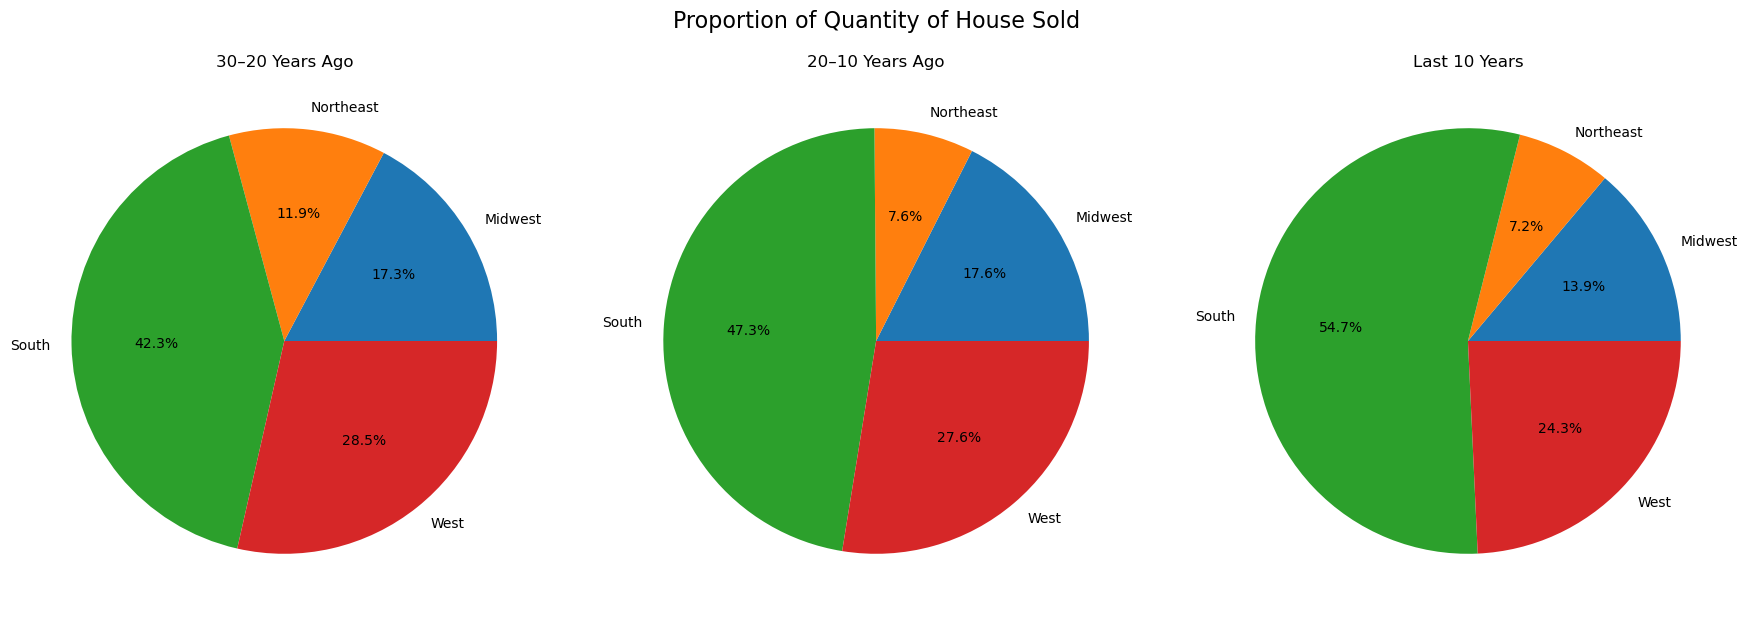

In [45]:
df_30_years_ago = pivot_df.tail(12*30).head(12*10)
df_20_years_ago = pivot_df.tail(12*20).head(12*10)
df_10_years_ago = pivot_df.tail(12*10)

pie_df1 = df_30_years_ago.mean(numeric_only=True)
pie_df2 = df_20_years_ago.mean(numeric_only=True)
pie_df3 = df_10_years_ago.mean(numeric_only=True)

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

axes[0].pie(pie_df1, labels=pie_df1.index, autopct='%1.1f%%')
axes[0].set_title("30–20 Years Ago")

axes[1].pie(pie_df2, labels=pie_df2.index, autopct='%1.1f%%')
axes[1].set_title("20–10 Years Ago")

axes[2].pie(pie_df3, labels=pie_df3.index, autopct='%1.1f%%')
axes[2].set_title("Last 10 Years")

plt.suptitle('Proportion of Quantity of House Sold', fontsize=16, y=1.02)

plt.tight_layout()
plt.show()

The above piecharts compare proportion of houses sold in different regions of USA, arranged by time. We can see that South region's proportion has increased over the years, together with west region, these two regions combined account for almost 80% of all houses sold. This shows the popularity or desires of home buyers on different area of the USA.

Executing ...
>>>

    SELECT per_name, cat_desc, dt_desc, dt_unit, val
    FROM clean_houses
    WHERE dt_desc IN ('All Houses', 'Houses that are Not Started', 'Houses that are Under Construction', 'Houses that are Completed') 
        AND cat_desc == 'New Single-family Houses For Sale'
        AND geo_desc == 'United States' -- Only the total
        AND per_name > '1980-01-01'
        AND is_adj == 0
    GROUP BY per_name, cat_desc, dt_desc, dt_unit, val

Fetched result:


dt_desc,per_name,All Houses,Houses that are Completed,Houses that are Not Started,Houses that are Under Construction
0,1980-02-01,380,115,58,207
1,1980-03-01,369,116,58,195
2,1980-04-01,359,120,56,184
3,1980-05-01,349,121,55,173
4,1980-06-01,341,117,54,171
...,...,...,...,...,...
436,2016-06-01,243,53,39,150
437,2016-07-01,236,54,37,145
438,2016-08-01,242,57,41,144
439,2016-09-01,245,58,43,144


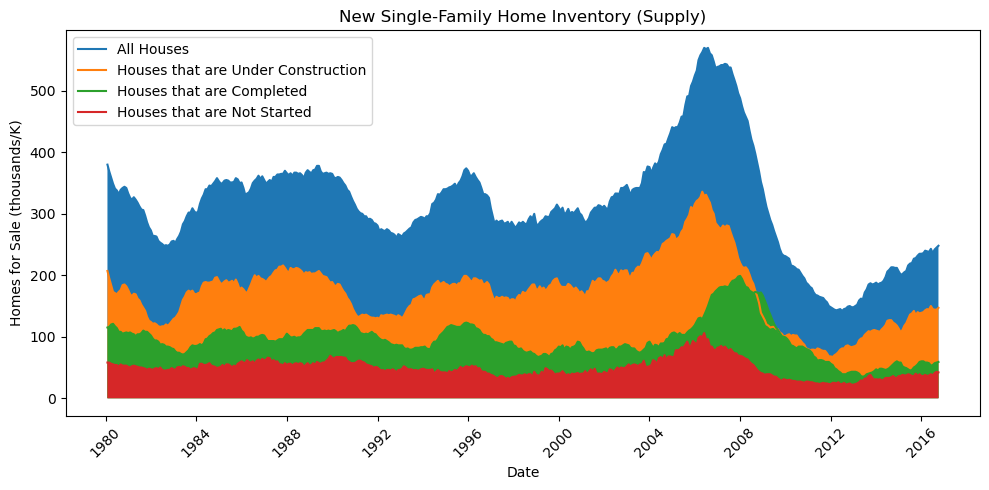

In [24]:
# Not started house, under construction house, completed house proportion over the year
# Geographical proportion to number of house sold
df = execute_to_df("""
    SELECT per_name, cat_desc, dt_desc, dt_unit, val
    FROM clean_houses
    WHERE dt_desc IN ('All Houses', 'Houses that are Not Started', 'Houses that are Under Construction', 'Houses that are Completed') 
        AND cat_desc == 'New Single-family Houses For Sale'
        AND geo_desc == 'United States' -- Only the total
        AND per_name > '1980-01-01'
        AND is_adj == 0
    GROUP BY per_name, cat_desc, dt_desc, dt_unit, val
""")

pivot_df = df.pivot(index='per_name', columns='dt_desc', values='val').reset_index() # Each type of houses is now a column
display(pivot_df)

arranged_col = pivot_df.columns[[0,1,4,2,3]]
pivot_df = pivot_df.loc[:,arranged_col]

plt.figure(figsize=(10, 5))

for i in range(1, 5):
    plt.plot(pivot_df['per_name'], pivot_df.iloc[:, i], label=pivot_df.columns[i])
    plt.fill_between(pivot_df['per_name'], pivot_df.iloc[:, i], alpha=1)

plt.xlabel('Date')
plt.ylabel('Homes for Sale (thousands/K)')
plt.title('New Single-Family Home Inventory (Supply)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend()
plt.show()

The above graph shows the number of new houses that are for sale, divided by the progress of completion.   
First of all, this graph also confirms what we have found previously about the speculative buying during the housing bubbles. The actual house that are being built and completed (green area), is the portion that are responsible for meeting actual housing needs. Starting from the year around 1998 the proportion of completed house (green area) is getting smaller compared to other, especially house under construction and all houses). This means the buyers are all interested about the value of the house in the future. In the year of 2007, the houses under construction and houses that are not started were bought at a disproportionately high ratio, nobody wants an actual house, they want a promise of a house in the future, an overly optimistic view of the market.  

The new finding here is that after the housing crisis, between year 2008 to 2012, houses that are completed were disproportionately high. This shows how dramatic the inventory can contract, which is an opportunity for those who can maintain construction capacity during downturns. Many had lost their labors or had declared bankruptcy during the crisis, creating many construction projects that cannot be completed. Therefore, one should recognize that construction capacity is a huge advantage on bad market and properly plan to maximize the benefits should the opportunity happen again.

Besides that, the metric of houses that are not started (red area) seems like an early indicator of the housing bubbles. It might worth looking into the number of houses that are not started or ratio of not-started house to completed-house as the predictor to forecast the market movement.

# Model building - Time Series Prediction Model

Our focus is to predict demand on number of houses. Naive prediction (predict using last observed value) is used as a baseline performance. 

We build a Vector Autoregressive model (VAR) to utilize several time series that influence each other (demand/supply/price). VAR model is similar to AR model that use past observation to fit a linear regression line to forecast the next value. VAR takes one step forward to utilize past observations of other time series also to perform regression. We saw previous monthly supply etc. have inverse relationship with number of houses sold, and also behave abnormally before the housing bubble. Therefore, it is worth a try to try to include these extra data to improve the forecasting.

We also try Vector Error Correction Model (VECM) to try to capture long trend pattern that VARIMA is unable to do. VAR or AR model have the downside of being performant on short forecast horizon but fail to capture long term trend or changes. The general consensus of suitable forecast horizon for ARIMA model is around few days to weeks, so our first method might be lacking when our data is monthly to yearly basis. VECM model have two components, AR term just like the VAR model, and cointegration term, which is the error correction term to "pullback" deviations from the equilibrium between two or more time series. We hope that there is such "equilibrium" between our variables of choice so that this model can capture this and forecast better.

Additionally, Holt-Winter model is also included. This model is comparatively simpler than previous VAR and VECM model, because it is fundamentally just a weighted average between past observations. There is a consideration that house demand might be too unpredictable that complex model are simply learning the noise. It is normally the case that the simpler model actually generalize better and therefore forecast better in such case.

The model building process includes data transformation, primarily to fit model assumption such as stationarity, and also process of parameter selection by exhaustive method.  
Finally, we compare the performance with our baseline model and interpret the model output before concluding.

In [25]:
# Gather the data 
metric_df = demand_metric.merge(price_metric, on='per_name').merge(monthly_supply_metric, on='per_name')
metric_df.columns = ['period','demand','price','monthly supply']

display(metric_df)

,period,demand,price,monthly supply
0,1963-01-01,42,17200,4.751269
1,1963-02-01,35,17700,6.103448
2,1963-03-01,44,18200,6.403471
3,1963-04-01,52,18200,5.038017
4,1963-05-01,58,17500,5.201365
...,...,...,...,...
641,2016-06-01,50,321600,5.225806
642,2016-07-01,54,295000,4.553055
643,2016-08-01,47,299600,5.121693
644,2016-09-01,45,314100,5.121951


In [26]:
from statsmodels.tsa.stattools import adfuller

# ARIMA model (and its variant) require stationarity, we perform Augmented Dicker Fuller Test (ADF-Test) to confirm stationarity
# Null hypothesis: A unit root is present in a time series sample, meaning the data is not stationary
# Alternate hypothesis: No root unit is present, the data is stationary
for variable in metric_df.columns[1:4]:
    result = adfuller(metric_df[variable].dropna())
    print(f'ADF-Test for {variable}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}\n')

for variable in metric_df.columns[1:4]:
    result = adfuller(metric_df[variable].diff().dropna())
    print(f'ADF-Test for first-order differenced {variable}:')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}\n')

# Alpha level / significance level is chosen at 0.10~0.20 threshold to favor decision to not perform differencing as it would mean loss of information
# Price require first order differencing at significance level = 0.10 to achieve stationarity
metric_df['price_diff'] = metric_df['price'].diff()
display(metric_df)

ADF-Test for demand:
ADF Statistic: -2.781430778637165
p-value: 0.06097559600470991

ADF-Test for price:
ADF Statistic: 0.7663688678656748
p-value: 0.9910734384144448

ADF-Test for monthly supply:
ADF Statistic: -3.2866569537475177
p-value: 0.015485546759103635

ADF-Test for first-order differenced demand:
ADF Statistic: -5.0244336772075044
p-value: 1.985027847912971e-05

ADF-Test for first-order differenced price:
ADF Statistic: -3.892703448834624
p-value: 0.0020892067713188197

ADF-Test for first-order differenced monthly supply:
ADF Statistic: -5.908694662207021
p-value: 2.670525911156611e-07



,period,demand,price,monthly supply,price_diff
0,1963-01-01,42,17200,4.751269,NaN
1,1963-02-01,35,17700,6.103448,500.0
2,1963-03-01,44,18200,6.403471,500.0
3,1963-04-01,52,18200,5.038017,0.0
4,1963-05-01,58,17500,5.201365,-700.0
...,...,...,...,...,...
641,2016-06-01,50,321600,5.225806,25600.0
642,2016-07-01,54,295000,4.553055,-26600.0
643,2016-08-01,47,299600,5.121693,4600.0
644,2016-09-01,45,314100,5.121951,14500.0


VAR model requires stationarity assumption of the time series. In the above step we are using ADF-Test to test for stationarity, and the result is to take first order differencing of price for all variables to achieve consider stationary at significance level of = 0.10.

Next, we will train all models and summarize after model building.

In [27]:
from sklearn.metrics import mean_squared_error

# Base Model performance
metric_df['naive_forecast'] = metric_df['demand'].shift(1)
# display(metric_df.tail(20))

rmse = np.sqrt(mean_squared_error(metric_df['demand'].iloc[1:], metric_df['naive_forecast'].iloc[1:]))
print(f'RMSE: {rmse}')

RMSE: 6.385667090136042


In [28]:
from statsmodels.tsa.api import VAR

# Prepare the data
model_data = metric_df.loc[:, ['demand','price_diff','monthly supply']]  # predictors (exclude period column)
model_data.index = pd.to_datetime(metric_df.iloc[:, 0])  # set period as index

model_data = model_data.dropna()
model_data = model_data.astype(float)

for i in [1,2,3,4,5,6,7,8,9,10]:
    model = VAR(model_data)
    results = model.fit(i)
    print('Order =', i)
    pred = results.fittedvalues.iloc[:,0].reset_index(drop=True)
    actual = metric_df['demand'].iloc[results.k_ar+1:].reset_index(drop=True)

    print(np.sqrt(mean_squared_error(actual, pred)))

Order = 1
6.268692346675621
Order = 2
6.174807961547186
Order = 3
6.099451674177971
Order = 4
5.920765491842592
Order = 5
5.73537433226715
Order = 6
5.640234791201595
Order = 7
5.4529395225126684
Order = 8
5.433048471389348
Order = 9
5.028585011460311
Order = 10
4.770283108466391


C:\Users\WEIJIET\anaconda3\envs\data_management_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\WEIJIET\anaconda3\envs\data_management_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\WEIJIET\anaconda3\envs\data_management_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\WEIJIET\anaconda3\envs\data_management_env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and 

In [46]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters model
model = ExponentialSmoothing(metric_df['demand'], seasonal='add', seasonal_periods=12)
fit = model.fit()

# Predict
pred = fit.fittedvalues

print("Additive Holt-Winters model:")
print(f"RMSE: {np.sqrt(mean_squared_error(metric_df['demand'], pred))}")
print(fit.params)

# Fit Holt-Winters model
model = ExponentialSmoothing(metric_df['demand'], seasonal='mul', seasonal_periods=12)
fit = model.fit()

# Predict
pred = fit.fittedvalues

print("Additive Holt-Winters model:")
print(f"RMSE: {np.sqrt(mean_squared_error(metric_df['demand'], pred))}")
print(fit.params)

Additive Holt-Winters model:
RMSE: 4.58797904520071
{'smoothing_level': 0.7768866472809874, 'smoothing_trend': nan, 'smoothing_seasonal': 1.3189711055284817e-09, 'damping_trend': nan, 'initial_level': 45.895060319957544, 'initial_trend': nan, 'initial_seasons': array([ -6.66329634,  -0.75857847,   8.34967975,   7.05056775,
         6.80683347,   4.65598951,   2.31990326,   2.72453265,
        -2.35223438,  -2.83616855,  -8.93688558, -11.71296324]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}
Additive Holt-Winters model:
RMSE: 4.297841028110992
{'smoothing_level': 0.7429310099949453, 'smoothing_trend': nan, 'smoothing_seasonal': 2.3201451389842418e-10, 'damping_trend': nan, 'initial_level': 26.81263093694094, 'initial_trend': nan, 'initial_seasons': array([1.45117215, 1.63445669, 1.91150117, 1.85151663, 1.84684197,
       1.78208234, 1.70711894, 1.72882929, 1.57030214, 1.55968784,
       1.37552875, 1.30308996]), 'use_boxcox': False, 'lamda': None, 'remove_bias': False}


In [30]:
from statsmodels.tsa.vector_ar.vecm import VECM

# Prepare data (stationary with cointegration)
data = metric_df.iloc[:,[1,2,3]]

param_pairs = [(a, b) for a in range(4) for b in range(4)]

for ar,coint in param_pairs:
    model = VECM(data, k_ar_diff=ar, coint_rank=coint)  # lag difference=1, cointegration rank=1
    vecm_res = model.fit()

    pred = pd.DataFrame(vecm_res.fittedvalues).iloc[:,0]
    print(f"Model is using AR order:{ar} ; Cointegration order: {coint};")
    print(np.sqrt(mean_squared_error(metric_df['demand'].iloc[vecm_res.k_ar:], pred)))

Model is using AR order:0 ; Cointegration order: 0;
6.385667090136042
Model is using AR order:0 ; Cointegration order: 1;
6.339278347996468
Model is using AR order:0 ; Cointegration order: 2;
6.338684268957149
Model is using AR order:0 ; Cointegration order: 3;
6.337321438491747
Model is using AR order:1 ; Cointegration order: 0;
6.326640690981497
Model is using AR order:1 ; Cointegration order: 1;
6.267818864514158
Model is using AR order:1 ; Cointegration order: 2;
6.264469504554593
Model is using AR order:1 ; Cointegration order: 3;
6.262194088983153
Model is using AR order:2 ; Cointegration order: 0;
6.275682269148784
Model is using AR order:2 ; Cointegration order: 1;
6.205285031426879
Model is using AR order:2 ; Cointegration order: 2;
6.1944689672923
Model is using AR order:2 ; Cointegration order: 3;
6.192150791070868
Model is using AR order:3 ; Cointegration order: 0;
6.076608865585016
Model is using AR order:3 ; Cointegration order: 1;
6.0441014294018
Model is using AR order:

### Model building result
Naive model RMSE: 6.386  
VAR model RMSE: 6.269 ~ 4.770  
Exponential Smoothing model RMSE: 4.588 (additive), 4.299 (multiplicative)  
VECM model RMSE: 6.386 ~ 6.030  
<br></br>
It is clear that VECM model is not outperforming the baseline naive model in terms of RMSE. VAR model can have lower RMSE than Naive model, but only after increasing the order to very high order. However, seeing how both VECM and VAR model have training performance that keep lowering as the model flexibility increases, they are sure to be the result of overfitting, which is not an ideal situation. Exponential smoothing model on the other hand however, is able to reach 4.299 RMSE, which is the best out of all models. Exponential smoothing is a simple model that uses weighted (exponential) average of previous observation, and the flexibility (learning capability) is much lesser than other complex model, which means the result is very unlikely to be overfitting.   
<br></br>
Due to the simplicity of the model and its superb performance, Exponential smoothing with multiplicative effect and alpha equals 0.743, and no seasonal or trend smoothing. This model is quite similar to naive model (special case where alpha = 1), with 75% of the influence coming from the most recent observation and 25% datapoint even older.  
<br></br>
Next graph shows the training,fitted, and forecasted value

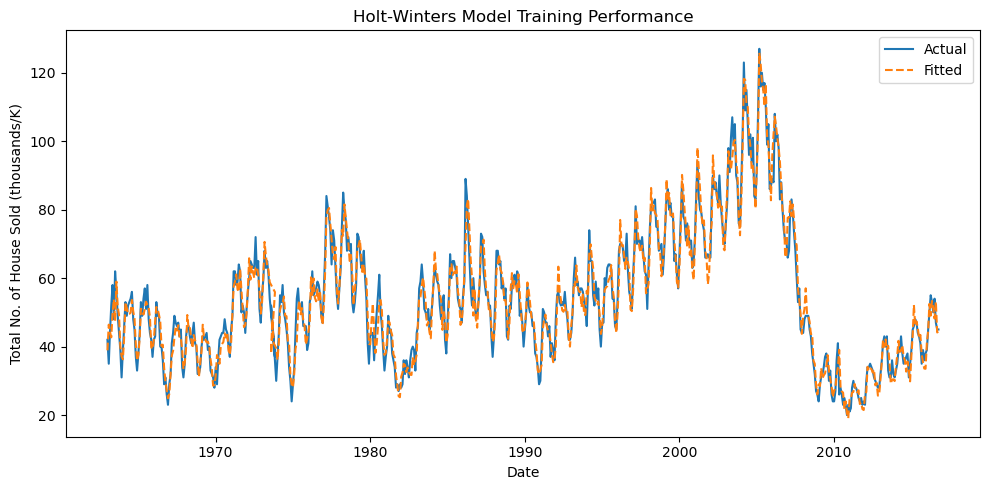

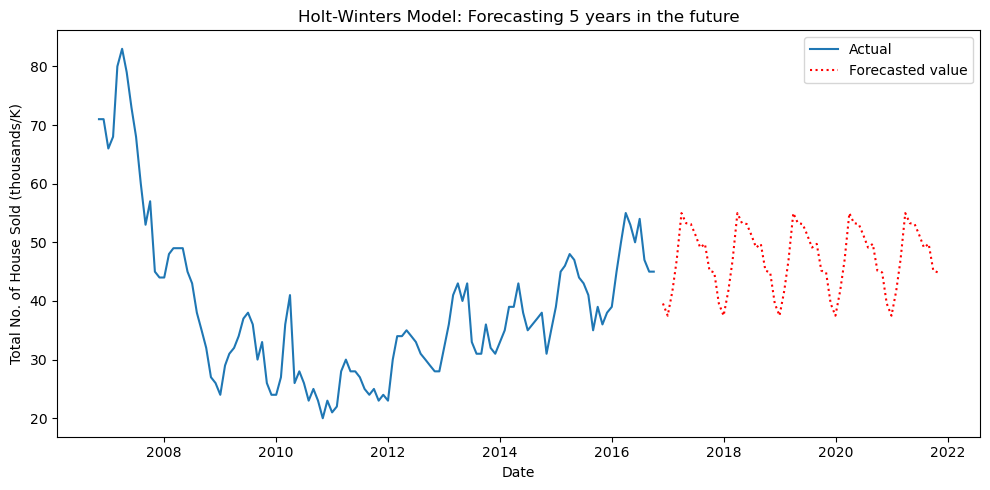

In [65]:
forecast_horizon = 12*5

# Forecast 120 periods ahead
forecast = fit.forecast(forecast_horizon)

# Create future period labels
future_periods = pd.date_range(metric_df['period'].iloc[-1], periods=forecast_horizon+1, freq='M')[1:]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(metric_df['period'], metric_df['demand'], label='Actual')
plt.plot(metric_df['period'], pred, label='Fitted', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Total No. of House Sold (thousands/K)')
plt.title('Holt-Winters Model Training Performance')
plt.legend()
plt.tight_layout()
plt.show()

# Plot the forecasted
plt.figure(figsize=(10, 5))
plt.plot(metric_df['period'].iloc[-120:], metric_df['demand'].iloc[-120:], label='Actual')
plt.plot(future_periods, forecast, label='Forecasted value', linestyle=':', color='red')
plt.xlabel('Date')
plt.ylabel('Total No. of House Sold (thousands/K)')
plt.title('Holt-Winters Model: Forecasting 5 years in the future')
plt.legend()
plt.tight_layout()
plt.show()

We can see that this model is fitting pretty well with the training observation. On the forecasted value, it does try to capture the yearly seasonal variation, but did not attempt to capture the trend or any turning point of any key event. This is the pros and cons of the model, it is simple and is able to capture the simple pattern pretty well, however, due to its simplicity, it simply does not have enough flexibility to model more complex pattern, especially the housing crisis that we saw on 2008.  
Future improvement can consider using more complex model such as neural network to perform ensemble learning / stacking on top of this base model. The idea is to use time series model to model the seasonal / trend components, and provide as input to the neural network where the neural network will be responsible for the identification of key turning points. Other than the complexity added, this method also have the ability to include exogeneous variable that is not a time-series, making the feature enginerring process more flexible, albeit also more difficult to navigate the feature space. 

# Conclusion

We have perform ETL using Hive to produce a clean dataset for analysis. In the process, we have manually upload the data into Hive, cleaned and transformed the data into our desired format, and finally load it into a partitioned table. Next, we perform analysis by querying the cleaned table and plot our data into graphs.  
<br></br>
In the analysis we looked at the demand, supply, and their relationship. From there, we have pointed out several findings from the graphs that correspond or related to the 2008 US housing crisis and several similar recessions. We have also fitted a regression line that shows the relationship between house prices and the year, and other findings that matches with findings from previous section Other than the global trend, we also looked into trends within USA itself, particularly the housing trends within different regions of USA, and also dissected it from the construction progress perspective. All of the analysis have been explained and provided with suggestions for different parties.
<br></br>
Lastly, we also built 4 forecasting models to predict the house demand in terms of number of house sold, where Holt-Winter (multiplicative) model turned out to be the best model with 4.299 RMSE. The downside of the model and the future improvement are discussed as well. 
<br></br>
In conclusion, this analysis discovers some trends about US housing market and reveal some directions that any house buyers, investors, real estate agents etc. should recognize and act accordingly. It is hope that data of more recent years can be obtain to perform more up-to-date analysis. 